# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from tqdm import tqdm
import gc
from sklearn.linear_model import LinearRegression, Ridge, Lasso

from sklearn.model_selection import StratifiedKFold,cross_val_score, GridSearchCV,RandomizedSearchCV, train_test_split, RepeatedStratifiedKFold#For splitting
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import fbeta_score, make_scorer

from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, f1_score, roc_auc_score, plot_roc_curve, plot_confusion_matrix, r2_score, mean_absolute_error,mean_squared_error, recall_score, precision_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.svm import SVR, LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool 
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, DMatrix
from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',None)
#from datetime import datetime
import warnings
warnings.filterwarnings("ignore")


# Reading Dataset

In [2]:
df = pd.read_csv('traffic.csv')
df.head()

,DateTime,Junction,Vehicles,ID
0,11/1/2015 0:00,1,15,20151101001
1,11/1/2015 1:00,1,13,20151101011
2,11/1/2015 2:00,1,10,20151101021
3,11/1/2015 3:00,1,7,20151101031
4,11/1/2015 4:00,1,9,20151101041


# Feature Engineering

In [3]:
#Extracting new features for the DateTime Column
df["DateTime"] = pd.to_datetime(df['DateTime'])


df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['day_of_month'] = df['DateTime'].dt.day
#df['Hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['Date']= df['DateTime'].dt.date
df['Time']= df['DateTime'].dt.hour

df['day_of_year']=  df['DateTime'].dt.dayofyear
df['Seconds'] = pd.to_timedelta(df['DateTime'].dt.strftime('%H:%M:%S')).dt.total_seconds().astype(int)


In [4]:
df.head()

,DateTime,Junction,Vehicles,ID,Year,Month,day_of_month,day_of_week,Date,Time,day_of_year,Seconds
0,2015-11-01 00:00:00,1,15,20151101001,2015,11,1,6,2015-11-01,0,305,0
1,2015-11-01 01:00:00,1,13,20151101011,2015,11,1,6,2015-11-01,1,305,3600
2,2015-11-01 02:00:00,1,10,20151101021,2015,11,1,6,2015-11-01,2,305,7200
3,2015-11-01 03:00:00,1,7,20151101031,2015,11,1,6,2015-11-01,3,305,10800
4,2015-11-01 04:00:00,1,9,20151101041,2015,11,1,6,2015-11-01,4,305,14400


In [5]:
#Checking DataType of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   DateTime      48120 non-null  datetime64[ns]
 1   Junction      48120 non-null  int64         
 2   Vehicles      48120 non-null  int64         
 3   ID            48120 non-null  int64         
 4   Year          48120 non-null  int64         
 5   Month         48120 non-null  int64         
 6   day_of_month  48120 non-null  int64         
 7   day_of_week   48120 non-null  int64         
 8   Date          48120 non-null  object        
 9   Time          48120 non-null  int64         
 10  day_of_year   48120 non-null  int64         
 11  Seconds       48120 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int64(9), object(1)
memory usage: 4.2+ MB


In [6]:

# Converting the DateTime Column into integer
df['DateTime'] = df['DateTime'].values.astype(np.int64) / 10 ** 9


In [7]:
df.columns

Index(['DateTime', 'Junction', 'Vehicles', 'ID', 'Year', 'Month',
       'day_of_month', 'day_of_week', 'Date', 'Time', 'day_of_year',
       'Seconds'],
      dtype='object')

In [8]:
df.head()

,DateTime,Junction,Vehicles,ID,Year,Month,day_of_month,day_of_week,Date,Time,day_of_year,Seconds
0,1.446336e+09,1,15,20151101001,2015,11,1,6,2015-11-01,0,305,0
1,1.446340e+09,1,13,20151101011,2015,11,1,6,2015-11-01,1,305,3600
2,1.446343e+09,1,10,20151101021,2015,11,1,6,2015-11-01,2,305,7200
3,1.446347e+09,1,7,20151101031,2015,11,1,6,2015-11-01,3,305,10800
4,1.446350e+09,1,9,20151101041,2015,11,1,6,2015-11-01,4,305,14400


In [9]:
#Encoding the Date Column
L_encoder =LabelEncoder()
df['Date'] = L_encoder.fit_transform(df['Date'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DateTime      48120 non-null  float64
 1   Junction      48120 non-null  int64  
 2   Vehicles      48120 non-null  int64  
 3   ID            48120 non-null  int64  
 4   Year          48120 non-null  int64  
 5   Month         48120 non-null  int64  
 6   day_of_month  48120 non-null  int64  
 7   day_of_week   48120 non-null  int64  
 8   Date          48120 non-null  int32  
 9   Time          48120 non-null  int64  
 10  day_of_year   48120 non-null  int64  
 11  Seconds       48120 non-null  int32  
dtypes: float64(1), int32(2), int64(9)
memory usage: 4.0 MB


# Creating New Features by Target Encoding Some Features

In [11]:
#Use Target Encoding to create new features  with aggregates : Std, Max,Min, Mean and Median
def agg_functions(df1):
    features= ['Junction', 'ID', 'Year', 'Month','day_of_month', 'day_of_week', 'Date', 'Time', 'day_of_year']
    for x in tqdm(features):
        t=df1.groupby(x)['Vehicles'].agg(['std','max','min','mean','median'])
        t.columns=[x+c+'_vehicles' for c in t.columns]
        t=t.astype({c:np.float32 for c in t.columns})
        t.reset_index(inplace=True)
#         display(t)
        # display(t.T.to_dict('list'))
        df1=df1.merge(t,on=x,how='left')
        gc.collect()
    return df1
# AGGREGATE SPECIFIC FEATURES WITH Vehicless
df2=agg_functions(df)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  5.29it/s]


In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48120 entries, 0 to 48119
Data columns (total 57 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   DateTime                     48120 non-null  float64
 1   Junction                     48120 non-null  int64  
 2   Vehicles                     48120 non-null  int64  
 3   ID                           48120 non-null  int64  
 4   Year                         48120 non-null  int64  
 5   Month                        48120 non-null  int64  
 6   day_of_month                 48120 non-null  int64  
 7   day_of_week                  48120 non-null  int64  
 8   Date                         48120 non-null  int32  
 9   Time                         48120 non-null  int64  
 10  day_of_year                  48120 non-null  int64  
 11  Seconds                      48120 non-null  int32  
 12  Junctionstd_vehicles         48120 non-null  float32
 13  Junctionmax_vehi

In [13]:
df2.isnull().sum()

DateTime                           0
Junction                           0
Vehicles                           0
ID                                 0
Year                               0
Month                              0
day_of_month                       0
day_of_week                        0
Date                               0
Time                               0
day_of_year                        0
Seconds                            0
Junctionstd_vehicles               0
Junctionmax_vehicles               0
Junctionmin_vehicles               0
Junctionmean_vehicles              0
Junctionmedian_vehicles            0
IDstd_vehicles                 48120
IDmax_vehicles                     0
IDmin_vehicles                     0
IDmean_vehicles                    0
IDmedian_vehicles                  0
Yearstd_vehicles                   0
Yearmax_vehicles                   0
Yearmin_vehicles                   0
Yearmean_vehicles                  0
Yearmedian_vehicles                0
M

In [14]:
#Dropping the IDstd_vehicles which had only NaN values
df2.drop('IDstd_vehicles', axis=1, inplace = True)

In [15]:
len(df2)

48120

# Building Baseline Model with the best performing Models (CatBoost, LGBM, RandomForest, and XGBoost

In [16]:
#Declaring Input and Output Variables
X = df2.drop(['Vehicles','Seconds'], axis=1)
y = df2['Vehicles']

In [17]:
#Train Test Split using 20% as test size
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42) 

# Training and evaluating baseline performance of the models below
# Catboost
cat = CatBoostRegressor(verbose=False)
cat.fit(X_train, y_train)
cat_pred = cat.predict(X_valid)
cat_RMSE = mean_squared_error(y_valid,cat_pred, squared=False)
print("CatBoost RMSE score on validation set is : ",cat_RMSE)
print('--------'*20)

# LGBM
lgb = LGBMRegressor(num_iterations=1000)
lgb.fit(X_train, y_train)
lgb_pred = lgb.predict(X_valid)
lgb_RMSE = mean_squared_error(y_valid,lgb_pred, squared=False)
print("LGBM RMSE score on validation set is : ",lgb_RMSE)
print('--------'*20)

# XGBoost
xg = XGBRegressor(n_estimators=1000)
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_valid)
xg_RMSE = mean_squared_error(y_valid,xg_pred, squared=False)
print("XGBoost RMSE score on validation set is : ",xg_RMSE)
print('--------'*20)


#RandomForest
rf =  RandomForestRegressor()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
rf_RMSE = mean_squared_error(y_valid,rf_pred, squared=False)
print("RandomForest RMSE score on validation set is : ",rf_RMSE)
print('--------'*20)



CatBoost RMSE score on validation set is :  0.08435926949445098
----------------------------------------------------------------------------------------------------------------------------------------------------------------
LGBM RMSE score on validation set is :  0.15315309156017243
----------------------------------------------------------------------------------------------------------------------------------------------------------------
XGBoost RMSE score on validation set is :  0.08029327874355069
----------------------------------------------------------------------------------------------------------------------------------------------------------------
RandomForest RMSE score on validation set is :  0.02668237795686666
----------------------------------------------------------------------------------------------------------------------------------------------------------------


## Checking for Overfitting with Stratified Cross Validation  and  Choosing the Best Model

In [18]:
# Creating a Function to perform Stratified Cross Validation to check for Overfitting
def stratified_cross_val(X, y, model, splits=8, seed=42):
    skf =  StratifiedKFold(n_splits=splits, shuffle=True, random_state=seed)

    RMSE_list = [] # a list to store our RMSE scores
    MAPE_list=[]# a list to store our MAPE scores
    Acc_list=[]# a list to store our Accuracy scores
    preds = []  # a list to store our prediction per splits
    model =  model# Instantiate your model

    i = 0
    for train, test in skf.split(X, y):
        x_train, x_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]
        model.fit(x_train, y_train)
        RMSE = mean_squared_error(y_test, model.predict(x_test), squared=False)
        MAPE= mean_absolute_percentage_error(y_test, model.predict(x_test))
        acc= (1-MAPE)*100
        print(f'Number of splits trained : {i} \t RMSE:  {RMSE}  \t MAPE: {MAPE}  \t Accuracy: {acc}')
        RMSE_list.append(RMSE)
        MAPE_list.append(MAPE)
        Acc_list.append(acc)
        i += 1
    
    # The mean of our validation scores    
    print('The average RMSE: ', np.mean(RMSE_list))
    print('The average MAPE: ', np.mean(MAPE_list)) 
    print('The average Accuracy: ', np.mean(Acc_list)) 



    return preds

In [19]:
#Checking for Overfitting in the Random Forest Model
preds = stratified_cross_val(X ,y , model = RandomForestRegressor())

Number of splits trained : 0 	 RMSE:  0.02786799425697705  	 MAPE: 5.492901120274057e-06  	 Accuracy: 99.99945070988797
Number of splits trained : 1 	 RMSE:  0.017596663327631226  	 MAPE: 3.4870834336101517e-06  	 Accuracy: 99.99965129165665
Number of splits trained : 2 	 RMSE:  0.014381686886653354  	 MAPE: 2.0663168421069747e-06  	 Accuracy: 99.99979336831579
Number of splits trained : 3 	 RMSE:  0.013400289075181112  	 MAPE: 1.8756727231813825e-06  	 Accuracy: 99.99981243272768
Number of splits trained : 4 	 RMSE:  0.07645208323359434  	 MAPE: 1.4846635773261445e-05  	 Accuracy: 99.99851533642268
Number of splits trained : 5 	 RMSE:  0.18810429359841313  	 MAPE: 2.030084802736021e-05  	 Accuracy: 99.99796991519726
Number of splits trained : 6 	 RMSE:  0.03605113206302649  	 MAPE: 7.93911962359084e-06  	 Accuracy: 99.99920608803764
Number of splits trained : 7 	 RMSE:  0.0739728781373069  	 MAPE: 9.459856184727959e-06  	 Accuracy: 99.99905401438153
The average RMSE:  0.05597837757234

In [20]:
#Checking for Overfitting in the CatBoost Model
preds = stratified_cross_val(X ,y , model = CatBoostRegressor(verbose=False))

Number of splits trained : 0 	 RMSE:  0.040608617068457836  	 MAPE: 0.0012366189400162236  	 Accuracy: 99.87633810599837
Number of splits trained : 1 	 RMSE:  0.0445503115957682  	 MAPE: 0.0011128317325228845  	 Accuracy: 99.88871682674771
Number of splits trained : 2 	 RMSE:  0.06265689707486986  	 MAPE: 0.0010919186934575972  	 Accuracy: 99.89080813065424
Number of splits trained : 3 	 RMSE:  0.08588385746785186  	 MAPE: 0.0012037347576616371  	 Accuracy: 99.87962652423383
Number of splits trained : 4 	 RMSE:  0.05757480569934216  	 MAPE: 0.0012816431656035901  	 Accuracy: 99.87183568343964
Number of splits trained : 5 	 RMSE:  0.1101514791979752  	 MAPE: 0.0012970621929368636  	 Accuracy: 99.8702937807063
Number of splits trained : 6 	 RMSE:  0.09750194215773997  	 MAPE: 0.0011880046193374933  	 Accuracy: 99.88119953806624
Number of splits trained : 7 	 RMSE:  0.08905875625779708  	 MAPE: 0.0012225054958742473  	 Accuracy: 99.87774945041258
The average RMSE:  0.07349833331497527
The

In [21]:
#Checking for Overfitting in the LGBM Model
preds = stratified_cross_val(X ,y , model = LGBMRegressor(num_iterations=1000))

Number of splits trained : 0 	 RMSE:  0.24268776260595742  	 MAPE: 0.0001662334518528632  	 Accuracy: 99.98337665481472
Number of splits trained : 1 	 RMSE:  0.09433848680418139  	 MAPE: 0.00010416983139597866  	 Accuracy: 99.98958301686041
Number of splits trained : 2 	 RMSE:  0.1617360487435008  	 MAPE: 0.00014544316882281766  	 Accuracy: 99.98545568311772
Number of splits trained : 3 	 RMSE:  0.22907040065248174  	 MAPE: 0.00012429374353141394  	 Accuracy: 99.98757062564685
Number of splits trained : 4 	 RMSE:  0.18315761459827273  	 MAPE: 0.00020510943852109203  	 Accuracy: 99.97948905614788
Number of splits trained : 5 	 RMSE:  0.3739128013717059  	 MAPE: 0.0001258855381653596  	 Accuracy: 99.98741144618346
Number of splits trained : 6 	 RMSE:  0.09040889242730583  	 MAPE: 0.00016724776563316703  	 Accuracy: 99.98327522343669
Number of splits trained : 7 	 RMSE:  0.40387504928155604  	 MAPE: 0.00017923000992371734  	 Accuracy: 99.98207699900763
The average RMSE:  0.222398382060620

In [22]:
#Checking for Overfitting in the XGBRegressor Model
preds = stratified_cross_val(X ,y , model = XGBRegressor(n_estimators=1000))

Number of splits trained : 0 	 RMSE:  0.0198244158661222  	 MAPE: 8.080859815394126e-06  	 Accuracy: 99.99919191401845
Number of splits trained : 1 	 RMSE:  0.0172268437046756  	 MAPE: 6.566137071389736e-06  	 Accuracy: 99.99934338629286
Number of splits trained : 2 	 RMSE:  0.04107201100116775  	 MAPE: 1.0016337875474793e-05  	 Accuracy: 99.99899836621246
Number of splits trained : 3 	 RMSE:  0.08729239923386474  	 MAPE: 1.2096231183969337e-05  	 Accuracy: 99.9987903768816
Number of splits trained : 4 	 RMSE:  0.037508764017879705  	 MAPE: 1.022543545631e-05  	 Accuracy: 99.99897745645437
Number of splits trained : 5 	 RMSE:  0.09357351703092122  	 MAPE: 1.1937430998623885e-05  	 Accuracy: 99.99880625690014
Number of splits trained : 6 	 RMSE:  0.09389427629668552  	 MAPE: 1.4083545870957008e-05  	 Accuracy: 99.9985916454129
Number of splits trained : 7 	 RMSE:  0.09038546311862655  	 MAPE: 1.7880229905803933e-05  	 Accuracy: 99.99821197700942
The average RMSE:  0.06009721128374291
Th

In [23]:
#Checking Cross Val Score for Random Forest Model
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
results = cross_val_score(RandomForestRegressor(), X, y, cv=skf) 
print("Cross Val Score with Stratifed KFold for RandomForest is:", np.mean(results)* 100)

Cross Val Score with Stratifed KFold for RandomForest is: 99.99854573025459


In [24]:
#Checking Cross Val Score for XGBoost Model
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
results = cross_val_score(XGBRegressor(n_estimators=1000), X, y, cv=skf) 
print("Cross Val Score with Stratifed KFold for XGBoost is:", np.mean(results)* 100)

Cross Val Score with Stratifed KFold for XGBoost is: 99.99892445314485


In [25]:
#Checking Cross Val Score for LGBM Model
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
results = cross_val_score(LGBMRegressor(num_iterations=1000), X, y, cv=skf)  
print("Cross Val Score with Stratifed KFold for LGBM is:", np.mean(results)* 100)

Cross Val Score with Stratifed KFold for LGBM is: 99.98576488714838


In [26]:
#Checking Cross Val Score for CatBoost Model
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)
results = cross_val_score(CatBoostRegressor(verbose=False), X, y, cv=skf) 
print("Cross Val Score with Stratifed KFold for CatBoost is:", np.mean(results)* 100)

Cross Val Score with Stratifed KFold for CatBoost is: 99.99861458707542


# Tuning Hyperparameters for the Chosen Model (RandomForest)

In [27]:
#RandomForest
# Tuning the selected Model: RandomForest
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42) 

rf =  RandomForestRegressor(random_state= 16,n_estimators=110)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
rf_RMSE = mean_squared_error(y_valid,rf_pred, squared=False)
print("RandomForest RMSE score on validation set is : ",rf_RMSE)
print('--------'*20)

RandomForest RMSE score on validation set is :  0.020008121981153638
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [28]:
#Checking the Tuned Model's Stratified CV for Overfitting
preds = stratified_cross_val(X ,y , model = RandomForestRegressor(random_state= 16,n_estimators=110))


Number of splits trained : 0 	 RMSE:  0.03541031019657815  	 MAPE: 6.330128916618813e-06  	 Accuracy: 99.99936698710835
Number of splits trained : 1 	 RMSE:  0.014709178312526638  	 MAPE: 2.442232095506698e-06  	 Accuracy: 99.99975577679045
Number of splits trained : 2 	 RMSE:  0.021915448571511405  	 MAPE: 2.680342928303728e-06  	 Accuracy: 99.99973196570717
Number of splits trained : 3 	 RMSE:  0.024275463015167534  	 MAPE: 3.163053468083877e-06  	 Accuracy: 99.9996836946532
Number of splits trained : 4 	 RMSE:  0.053759163016662476  	 MAPE: 1.0390180746434111e-05  	 Accuracy: 99.99896098192535
Number of splits trained : 5 	 RMSE:  0.18443074997994674  	 MAPE: 1.8807221226968698e-05  	 Accuracy: 99.99811927787731
Number of splits trained : 6 	 RMSE:  0.026297064926537758  	 MAPE: 4.872218507683595e-06  	 Accuracy: 99.99951277814924
Number of splits trained : 7 	 RMSE:  0.06496629318940039  	 MAPE: 1.042547157320046e-05  	 Accuracy: 99.99895745284269
The average RMSE:  0.0532204589010

# Checking Feature Importance to get rid of unimportant Features

In [29]:
#Creating a DataFrame that shows each feature and its importance to the Model
cat_viz= pd.DataFrame({'Feature':X.columns, 'Importance':rf.feature_importances_}).sort_values(by="Importance",ascending=False)
cat_viz

,Feature,Importance
15,IDmax_vehicles,2.855450e-01
16,IDmin_vehicles,2.621490e-01
18,IDmedian_vehicles,2.458333e-01
17,IDmean_vehicles,2.064538e-01
40,Datemax_vehicles,3.406385e-06
50,day_of_yearmax_vehicles,1.889023e-06
30,day_of_monthmax_vehicles,1.696991e-06
53,day_of_yearmedian_vehicles,1.319575e-06
11,Junctionmax_vehicles,1.047322e-06
12,Junctionmin_vehicles,8.543784e-07


<AxesSubplot:xlabel='Importance', ylabel='Feature'>

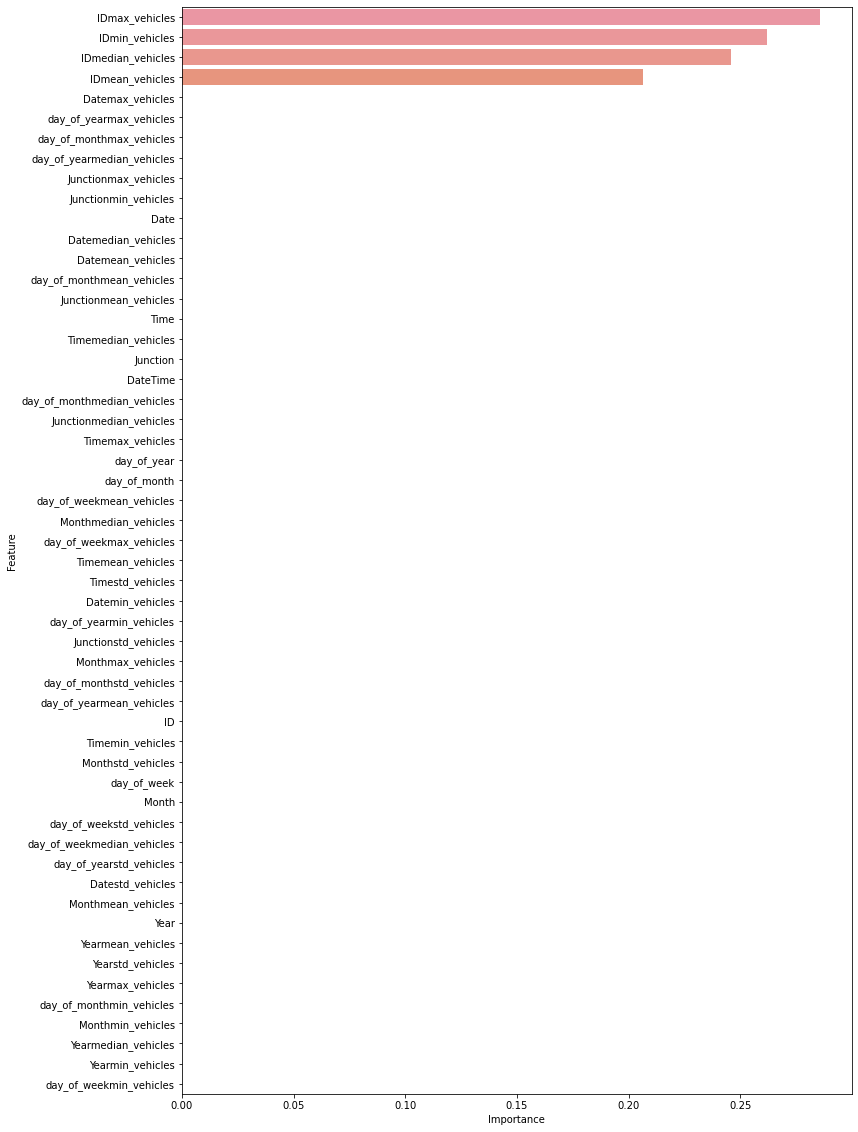

In [30]:
#Plotting the Feature Importance
plt.figure(figsize= (12,20))
sns.barplot(x='Importance', y= 'Feature', data=cat_viz, label="Feature Importances", orient= 'h')#, color_palette='tab10')

In [31]:
#Finding the columns that had no importance to the model performance
useless_cols = list(cat_viz.loc[cat_viz['Importance']==0.00000000000000]['Feature'])
useless_cols

['Yearstd_vehicles',
 'Yearmax_vehicles',
 'day_of_monthmin_vehicles',
 'Monthmin_vehicles',
 'Yearmedian_vehicles',
 'Yearmin_vehicles',
 'day_of_weekmin_vehicles']

# Dropping The Useless Columns and Building a Model with the useful Columns

In [32]:
#Dropping the useless columns
X1= X.drop(useless_cols,axis=1).reset_index(drop=True)

In [33]:
#Training a Model with the new features and evaluating its Performance
X_train, X_valid, y_train, y_valid = train_test_split(X1, y, test_size=0.2, random_state=42) 

rf =  RandomForestRegressor(random_state= 16,n_estimators=100)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_valid)
rf_RMSE = mean_squared_error(y_valid,rf_pred, squared=False)
rf_MAPE= mean_absolute_percentage_error(y_valid,rf_pred)
rf_acc= (1-rf_MAPE)* 100

print("RandomForest RMSE score on validation set is : ",rf_RMSE)
print("RandomForest MAPE score on validation set is : ",rf_MAPE)
print("RandomForest Accuracy score on validation set is : ",rf_acc)
print('--------'*20)

RandomForest RMSE score on validation set is :  0.021600544927087652
RandomForest MAPE score on validation set is :  4.180936646533357e-06
RandomForest Accuracy score on validation set is :  99.99958190633535
----------------------------------------------------------------------------------------------------------------------------------------------------------------


In [34]:
#Checking the Final Model's Stratified CV for Overfitting
preds = stratified_cross_val(X1 ,y , model = RandomForestRegressor(random_state= 16))

Number of splits trained : 0 	 RMSE:  0.018138196746469187  	 MAPE: 3.16764967607931e-06  	 Accuracy: 99.99968323503239
Number of splits trained : 1 	 RMSE:  0.015785869708714588  	 MAPE: 2.718916397402286e-06  	 Accuracy: 99.99972810836026
Number of splits trained : 2 	 RMSE:  0.023746373919278817  	 MAPE: 3.5130797329528486e-06  	 Accuracy: 99.99964869202671
Number of splits trained : 3 	 RMSE:  0.025205060912331653  	 MAPE: 3.595341921994697e-06  	 Accuracy: 99.9996404658078
Number of splits trained : 4 	 RMSE:  0.05301688120245836  	 MAPE: 1.0294040348935993e-05  	 Accuracy: 99.9989705959651
Number of splits trained : 5 	 RMSE:  0.17520504553251287  	 MAPE: 1.9487159495326304e-05  	 Accuracy: 99.99805128405048
Number of splits trained : 6 	 RMSE:  0.02156395502397409  	 MAPE: 4.149811779238496e-06  	 Accuracy: 99.99958501882207
Number of splits trained : 7 	 RMSE:  0.055442900464983666  	 MAPE: 8.731188576863465e-06  	 Accuracy: 99.9991268811423
The average RMSE:  0.048513035438840

# Conclusion 

**Creating New Features by Target Encoding Some Features**

We used Target Encoding to create new features with aggregates : Std, Max,Min, Mean and Median


**Building Baseline Model with the best performing Models (CatBoost, LGBM, RandomForest, and XGBoost**

We built Baseline Model with the best performing Models (CatBoost, LGBM, RandomForest, and XGBoost) and the Root Mean Square Error of the Random Forest Regressor was very much lower and close to 0, which means the Random Forest Regressor model will perform well.


**Checking for Overfitting with Stratified Cross Validation and Choosing the Best Model**

None of the models was overfitting after we tested with stratified cross-validation. Random Forest was still the best-performing model.


**Tuning Hyperparameters for the Chosen Model (RandomForest)**

We optimized the chosen model which was Random Forest to improve the performance.


**Checking Feature Importance to get rid of unimportant Features**

We checked the important of all the features to see which ones added noise to our models and we noticed the features with no importance to the models and dropped them.

After we dropped useless columns, and RandomForest Model was trained again giving us an Accuracy score on validation set which was about 99.9% value.